# Analyze customer data from Austin, TX. 

In this lab, we will analyze various features of customer energy usage data from the Pecan Street dataset. The dataset we aim to explore is for the month of January 2017 from various customers in Austin, TX.

Distinguish which houses have rooftop photovoltaic (PV) panels and which ones do not. For the houses that do not have PV panels, try to predict how much money they would save, given Austin's retail energy rates.

Given the temperature profile, can you predict which houses have AC?

In [10]:
# Start with customary imports.

import tensorflow as tf
import numpy as np
import pandas as pd
import random
import datetime
import math
from sklearn.model_selection import train_test_split
from sklearn import preprocessing, linear_model
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

## Understand and parse the dataset

There are two csv files that we will utilize in this lab:
1. 'dataport-metadata.csv': It contains the details of what data is available from each house in the entire Pecan Street dataset.
2. 'July2017.csv': It contains the energy data from houses in Austin for the month of July.

### Parse the metadata file.

Only consider customers from Austin, TX for which electricity usage data is present.


In [11]:
# Load the 'metadata' file that contains information about individual houses into a pandas dataframe.
dfCityCustomers = pd.read_csv("dataport-metadata.csv", index_col=0)

# Only consider the houses that are in Austin and have power consumption data.
dfCityCustomers = dfCityCustomers.loc[(dfCityCustomers['city'] == 'Austin') & (dfCityCustomers['use'] == 'yes')]

# Restrict attention to useful columns.
dfCityCustomers = dfCityCustomers[['date_enrolled', 'date_withdrawn', 
                                   'building_type', 'total_square_footage', 'first_floor_square_footage',
                                   'pv', 'air1', 'air2', 'air3', 'airwindowunit1',
                                   'gen', 'use', 'grid']]

# Replace binary data with zeros and ones.
binaryColumns = ['pv', 'air1', 'air2', 'air3', 'airwindowunit1', 'gen', 'use', 'grid']
for bColumn in binaryColumns:
    dfCityCustomers[bColumn] = dfCityCustomers[bColumn].map({'yes' : 1}).fillna(0)

start_day = datetime.datetime.strptime('2017-07-01', '%Y-%m-%d').date()
    
dfCityCustomers['date_enrolled'] = [datetime.datetime.strptime(x, "%Y-%m-%d") 
                                    for x in dfCityCustomers['date_enrolled']]

dfCityCustomers = dfCityCustomers.loc[(dfCityCustomers['date_enrolled'] <= '2017-07-01')]
print("Parsed the metadata file successfully.")

Parsed the metadata file successfully.


### Parse the energy usage data.

Here, we shall clean the data. 

1. The data downloaded from dataport.cloud has a mislabeled column. Correct that.
2. Split the 'localhour' field into two fiels: actual date and an hour of day.
3. Only choose data from households that are 'Single-Family Homes'.
4. Make sure there is data from 31 days.
5. Ensure that the metadata includes the square footage for the entire home and its first floor.

Finally, create a pandas dataframe where indices are house id's.

In [12]:
# Load the data from Jan 2017 from houses in Texas.
dfData = pd.read_csv("July2017.csv")

# Cleanup item 1. Alter the column names because there is an error in the downloaded data. The column names
# 'dataid' and 'localhour' are switched in the .csv file. Correct it. 
# Cleanup item 2. Split the hour and the day in the field 'localhour' and convert the date to an 
# actual datetime object.

dfData.columns = [x.lstrip() for x in dfData.columns]
dfData = dfData[['dataid', 'localhour', 'use', 'grid', 'gen', 'air1', 'air2', 'air3', 'airwindowunit1']]
dfData.columns = ['date', 'dataid', 'use', 'grid', 'gen', 'air1', 'air2', 'air3', 'airwindowunit1']

dfData['hour'] = [datetime.datetime.strptime(x[:-3], "%Y-%m-%d %H:%M:%S").hour for x in dfData['date']]
dfData['date'] = [datetime.datetime.strptime(x[:-3], "%Y-%m-%d %H:%M:%S").date() for x in dfData['date']]

# Create a dataframe where indices are house id's.
dfData_houses = pd.DataFrame(columns=['ac', 'pv', 'area', 'area_floor', 'data'])

for house_id in dfData['dataid'].unique():
    
    # Make sure that each house with consumption data is also in metadata.
    if house_id in dfCityCustomers.index.values:
        dfData_one_house = dfData.loc[dfData['dataid'] == house_id]

        # Cleanup item 3, 4, 5.
        if ((len(dfData_one_house) >= 24 * 31) & 
        (np.sum(dfData_one_house['use'].values) != 0) & 
        (dfCityCustomers.loc[house_id, 'building_type'] == 'Single-Family Home') & 
        (np.isnan(dfCityCustomers.loc[house_id, 'total_square_footage']) == False) & 
        (np.isnan(dfCityCustomers.loc[house_id, 'first_floor_square_footage']) == False)):
            
            # Create a pandas dataframe with house id's as indices and has the following items: 
            # 1. Binary status: "ac", "pv".
            # 2. Total square footrage, and the square footage of the first floor.
            
            is_ac_in_house =  (dfCityCustomers.loc[house_id, 'air1'] 
                               or dfCityCustomers.loc[house_id, 'air2']
                               or dfCityCustomers.loc[house_id, 'air3']
                               or dfCityCustomers.loc[house_id, 'airwindowunit1']
                              )
            
            dfData_houses.loc[house_id] = [is_ac_in_house, 
                                           dfCityCustomers.loc[house_id, 'pv'],
                                           dfCityCustomers.loc[house_id, 'total_square_footage'],
                                           dfCityCustomers.loc[house_id, 'first_floor_square_footage'],
                                           dfData_one_house
                                          ]

# Define a function that retrieves the hourly energy profile from the column in "field" from a
# specific house and day. The day is measured as number of days since the start date of Jan 1, 2017.

def energy_day(house_id, day, field): 
    date_day = start_day + datetime.timedelta(days=day)
    dfData_house = dfData_houses.loc[house_id, 'data']
    return dfData_house.loc[dfData_house['date'] == date_day].sort_values(by=['hour'])[field].values

# Define a function that retrieves the aggregate energy consumed (or produced) as detailed in the column 
# named "field" from a specific house over all days.

def total_energy_all_days(house_id, field): 
    total_energy = 0
    for day in range(31):
        total_energy += np.sum(energy_day(house_id, day, field))
    return total_energy


# Cleanup item 4 continued: Delete data from houses where the date and hour do not perfectly 
# align with the 31 days in July, and hours being from 0 to 23.
house_ids_to_delete = []
for house_id in dfData_houses.index.values:
    for day in range(31):
        if len(energy_day(house_id, day, 'grid')) != 24:
            house_ids_to_delete.append(house_id)
            continue

dfData_houses.drop(house_ids_to_delete, inplace=True)

print("Data loaded and parsed successfully from %d single-family homes." % (len(dfData_houses)))

del dfData , dfCityCustomers           

Data loaded and parsed successfully from 222 single-family homes.


## Distinguish houses with rooftop solar panels from daily energy usage profile.

Take data of energy drawn from the grid for 10 days and do logistic regression.

### Q1. Explain Logistic regression. (10 points)

logistic(z) = 1 / (1 + e^-z), 
x = inputVector, 
y = output, 
z = wTx + b

| Logistic regression serves as a statistical methodology to predict an outcome based on observations of a data set. It depends on the dependent variable by understanding and evaluating the relationship between independent variables/features. 

In [13]:
print("Number of houses with PV panels = %d" % (len(dfData_houses.loc[dfData_houses['pv'] == 1])) )
print("Number of houses without PV panels = %d" % (len(dfData_houses.loc[dfData_houses['pv'] == 0])) )

XX = []
YY = []

days_data = random.sample(range(31), 10)

for house_id in dfData_houses.index.values:
    XX.append(np.ravel([energy_day(house_id, day, 'grid') for day in days_data]))
    YY.append(dfData_houses.loc[house_id, 'pv'])

YY = np.reshape(YY, (-1, 1))

train_X, test_X, train_Y, test_Y = train_test_split(XX, YY, test_size=.2, shuffle=True)

train_X = tf.dtypes.cast(train_X, tf.float32)
test_X = tf.dtypes.cast(test_X, tf.float32)
train_Y = tf.dtypes.cast(train_Y, tf.float32)
test_Y = tf.dtypes.cast(test_Y, tf.float32)

del XX, YY

Number of houses with PV panels = 146
Number of houses without PV panels = 76


### Q2. Design the neural network. In the next cell, fill in the missing pieces. (30 points)


In [15]:
nDimX = np.shape(train_X)[1]
nDimY = np.shape(train_Y)[1]

weight = tf.Variable(tf.random.truncated_normal(shape = [nDimX, nDimY]))
bias = tf.Variable(tf.zeros(nDimY))

trainable_variables = [weight, bias]

@tf.function
def neuralNetworkModel(X):
    global weight, bias
    # enter code here (hint: tf.nn.sigmoid may be useful)
    return tf.nn.sigmoid(tf.matmul(X, weight) + bias)

loss_fn = tf.losses.BinaryCrossentropy(from_logits = True, reduction = tf.losses.Reduction.SUM)
optimizer = tf.optimizers.Adam(learning_rate = 0.001)

# Define number of epochs
nEpoch = 1000

# Define the training scheme
def train(model, x_set, y_set):
    for epoch in range(nEpoch):
        # Fit the data and compute the gradients
        with tf.GradientTape() as tape:
            prediction = model(x_set)
            loss = loss_fn(y_true=y_set, y_pred=prediction)
            
            # Print update
            lossEpoch = loss.numpy()
            print("Epoch: %d, Loss: = %1.1f" % (epoch + 1, lossEpoch))
            
            # Optimize the weights
            gradients = tape.gradient(loss, trainable_variables)
            optimizer.apply_gradients(zip(gradients, trainable_variables))


# Train the model
print ("Start neural network training.")
train(neuralNetworkModel, train_X, train_Y)

test_prediction = tf.math.round(neuralNetworkModel(test_X))
test_accuracy = tf.math.reduce_mean(tf.dtypes.cast(tf.math.equal(test_Y, test_prediction), tf.float32))
print("Accuracy of logistic regression on test data = %.2f percent." % (test_accuracy * 100))

Start neural network training.
Epoch: 1, Loss: = 99.6
Epoch: 2, Loss: = 99.0
Epoch: 3, Loss: = 98.5
Epoch: 4, Loss: = 97.9
Epoch: 5, Loss: = 97.4
Epoch: 6, Loss: = 96.9
Epoch: 7, Loss: = 96.5
Epoch: 8, Loss: = 96.0
Epoch: 9, Loss: = 95.5
Epoch: 10, Loss: = 95.0
Epoch: 11, Loss: = 94.5
Epoch: 12, Loss: = 93.8
Epoch: 13, Loss: = 93.3
Epoch: 14, Loss: = 93.0
Epoch: 15, Loss: = 92.8
Epoch: 16, Loss: = 92.7
Epoch: 17, Loss: = 92.6
Epoch: 18, Loss: = 92.4
Epoch: 19, Loss: = 92.3
Epoch: 20, Loss: = 92.1
Epoch: 21, Loss: = 92.0
Epoch: 22, Loss: = 91.8
Epoch: 23, Loss: = 91.7
Epoch: 24, Loss: = 91.6
Epoch: 25, Loss: = 91.5
Epoch: 26, Loss: = 91.4
Epoch: 27, Loss: = 91.3
Epoch: 28, Loss: = 91.2
Epoch: 29, Loss: = 91.0
Epoch: 30, Loss: = 90.9
Epoch: 31, Loss: = 90.7
Epoch: 32, Loss: = 90.6
Epoch: 33, Loss: = 90.5
Epoch: 34, Loss: = 90.4
Epoch: 35, Loss: = 90.3
Epoch: 36, Loss: = 90.2
Epoch: 37, Loss: = 90.2
Epoch: 38, Loss: = 90.2
Epoch: 39, Loss: = 90.1
Epoch: 40, Loss: = 90.1
Epoch: 41, Loss: =

Epoch: 320, Loss: = 84.1
Epoch: 321, Loss: = 84.1
Epoch: 322, Loss: = 84.0
Epoch: 323, Loss: = 84.0
Epoch: 324, Loss: = 84.0
Epoch: 325, Loss: = 84.0
Epoch: 326, Loss: = 84.0
Epoch: 327, Loss: = 84.0
Epoch: 328, Loss: = 84.0
Epoch: 329, Loss: = 84.0
Epoch: 330, Loss: = 84.0
Epoch: 331, Loss: = 83.9
Epoch: 332, Loss: = 83.9
Epoch: 333, Loss: = 83.9
Epoch: 334, Loss: = 83.9
Epoch: 335, Loss: = 83.9
Epoch: 336, Loss: = 83.9
Epoch: 337, Loss: = 83.9
Epoch: 338, Loss: = 83.9
Epoch: 339, Loss: = 83.9
Epoch: 340, Loss: = 83.9
Epoch: 341, Loss: = 83.9
Epoch: 342, Loss: = 83.8
Epoch: 343, Loss: = 83.8
Epoch: 344, Loss: = 83.8
Epoch: 345, Loss: = 83.8
Epoch: 346, Loss: = 83.8
Epoch: 347, Loss: = 83.8
Epoch: 348, Loss: = 83.8
Epoch: 349, Loss: = 83.8
Epoch: 350, Loss: = 83.8
Epoch: 351, Loss: = 83.8
Epoch: 352, Loss: = 83.8
Epoch: 353, Loss: = 83.8
Epoch: 354, Loss: = 83.7
Epoch: 355, Loss: = 83.7
Epoch: 356, Loss: = 83.7
Epoch: 357, Loss: = 83.7
Epoch: 358, Loss: = 83.7
Epoch: 359, Loss: = 83.7


Epoch: 665, Loss: = 80.0
Epoch: 666, Loss: = 80.0
Epoch: 667, Loss: = 80.0
Epoch: 668, Loss: = 80.0
Epoch: 669, Loss: = 80.0
Epoch: 670, Loss: = 80.0
Epoch: 671, Loss: = 80.0
Epoch: 672, Loss: = 80.0
Epoch: 673, Loss: = 80.0
Epoch: 674, Loss: = 80.0
Epoch: 675, Loss: = 79.9
Epoch: 676, Loss: = 79.9
Epoch: 677, Loss: = 79.9
Epoch: 678, Loss: = 79.9
Epoch: 679, Loss: = 79.9
Epoch: 680, Loss: = 79.9
Epoch: 681, Loss: = 79.9
Epoch: 682, Loss: = 79.9
Epoch: 683, Loss: = 79.9
Epoch: 684, Loss: = 79.9
Epoch: 685, Loss: = 79.9
Epoch: 686, Loss: = 79.9
Epoch: 687, Loss: = 79.9
Epoch: 688, Loss: = 79.9
Epoch: 689, Loss: = 79.9
Epoch: 690, Loss: = 79.9
Epoch: 691, Loss: = 79.9
Epoch: 692, Loss: = 79.9
Epoch: 693, Loss: = 79.9
Epoch: 694, Loss: = 79.9
Epoch: 695, Loss: = 79.9
Epoch: 696, Loss: = 79.9
Epoch: 697, Loss: = 79.9
Epoch: 698, Loss: = 79.9
Epoch: 699, Loss: = 79.9
Epoch: 700, Loss: = 79.9
Epoch: 701, Loss: = 79.9
Epoch: 702, Loss: = 79.9
Epoch: 703, Loss: = 79.9
Epoch: 704, Loss: = 79.9


### Q3.  Print the classification report on the test data. The function 'classification_report' from 'sklearn.metrics' might prove useful. (10 points)

In [16]:
# Enter code here
print(classification_report(test_Y, test_prediction))

              precision    recall  f1-score   support

         0.0       0.95      0.95      0.95        20
         1.0       0.96      0.96      0.96        25

    accuracy                           0.96        45
   macro avg       0.95      0.95      0.96        45
weighted avg       0.96      0.96      0.96        45



### Q4. Based on the classification report you obtain, your classifier is better in which of the following tasks? (20 points)
1. If it identifies a house to have a PV panel, then it has a PV panel.
2. If there is a PV panel, then it identifies that it has a PV panel.

Furthermore, complete the code below to plot the energy drawn from the grid from houses with and without PV panels.

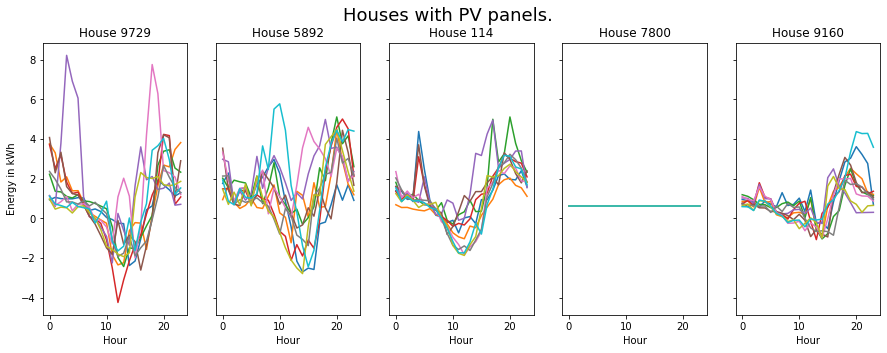

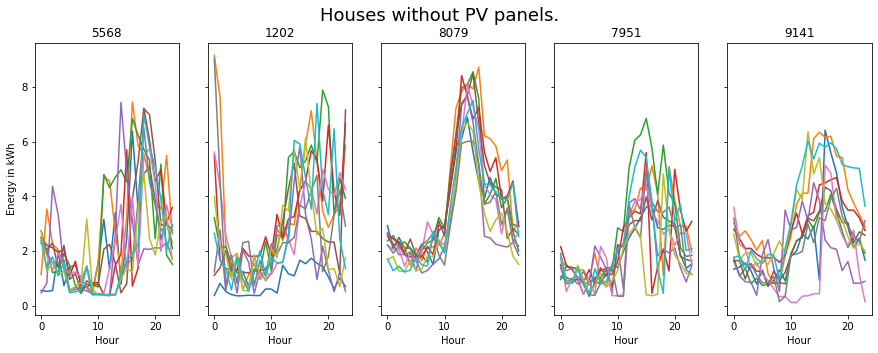

In [19]:
# Plot energy drawn from grid for houses with PV's.
house_id_pv = random.sample(list(dfData_houses.loc[dfData_houses['pv'] == 1].index.values), 5)

fig, axs = plt.subplots(1, 5, sharey=True, figsize=(15,5))

for tt, house_id in enumerate(house_id_pv):
    for day in days_data:
        # Enter code here
        axs[tt].plot(energy_day(house_id, day, 'grid'))
        axs[tt].set_title("House " + str(house_id))
fig.suptitle('Houses with PV panels.', fontsize=18)

for ax in axs.flat:
    ax.set(xlabel='Hour', ylabel='Energy in kWh')
for ax in axs.flat:
    ax.label_outer()

house_id_not_pv = random.sample(list(dfData_houses.loc[dfData_houses['pv'] == 0].index.values), 5)

fig, axs = plt.subplots(1, 5, sharey=True, figsize=(15,5))
axs = axs.ravel()

for tt, house_id in enumerate(house_id_not_pv):
    for day in days_data:
    # Enter code here
        axs[tt].plot(energy_day(house_id, day, 'grid'))
        axs[tt].set_title(house_id)

fig.suptitle('Houses without PV panels.', fontsize=18)        

for ax in axs.flat:
    ax.set(xlabel='Hour', ylabel='Energy in kWh')
for ax in axs.flat:
    ax.label_outer()

### Q5. Design a classifier to distinguish between houses with and without PV based on the plots. Print your classification report, and compare it with logistic regression. (10 points, bonus) 

It is clear that the original model with the Binary Cross Entropy loss function and Adam optimizer is much better than that of Mean Squared Error loss and an SGD optimizer. The accuracies are so far apart, it is clear which is better to use. 

In [31]:
# Compare the performance of a neural network based classifier with an educated guess.
nDimX = np.shape(train_X)[1]
nDimY = np.shape(train_Y)[1]

weight = tf.Variable(tf.random.truncated_normal(shape = [nDimX, nDimY]))
bias = tf.Variable(tf.zeros(nDimY))

trainable_variables = [weight, bias]

@tf.function
def neuralNetworkModel(X):
    global weight, bias
    # enter code here (hint: tf.nn.sigmoid may be useful)
    return tf.nn.sigmoid(tf.matmul(X, weight) + bias)

loss_fn = tf.losses.MeanSquaredError(reduction = tf.keras.losses.Reduction.SUM)
optimizer = tf.optimizers.SGD(learning_rate = 0.1)

# Define number of epochs
nEpoch = 1000

# Define the training scheme
def train(model, x_set, y_set):
    for epoch in range(nEpoch):
        # Fit the data and compute the gradients
        with tf.GradientTape() as tape:
            prediction = model(x_set)
            loss = loss_fn(y_true=y_set, y_pred=prediction)
            
            # Print update
            lossEpoch = loss.numpy()
            print("Epoch: %d, Loss: = %1.1f" % (epoch + 1, lossEpoch))
            
            # Optimize the weights
            gradients = tape.gradient(loss, trainable_variables)
            optimizer.apply_gradients(zip(gradients, trainable_variables))


# Train the model
print ("Start neural network training.")
train(neuralNetworkModel, train_X, train_Y)

test_prediction = tf.math.round(neuralNetworkModel(test_X))
test_accuracy = tf.math.reduce_mean(tf.dtypes.cast(tf.math.equal(test_Y, test_prediction), tf.float32))
print("Accuracy of logistic regression on test data = %.2f percent." % (test_accuracy * 100))

Start neural network training.
Epoch: 1, Loss: = 80.5
Epoch: 2, Loss: = 56.8
Epoch: 3, Loss: = 56.8
Epoch: 4, Loss: = 56.8
Epoch: 5, Loss: = 56.8
Epoch: 6, Loss: = 56.8
Epoch: 7, Loss: = 56.8
Epoch: 8, Loss: = 56.8
Epoch: 9, Loss: = 56.8
Epoch: 10, Loss: = 56.8
Epoch: 11, Loss: = 56.8
Epoch: 12, Loss: = 56.8
Epoch: 13, Loss: = 56.8
Epoch: 14, Loss: = 56.7
Epoch: 15, Loss: = 56.7
Epoch: 16, Loss: = 56.7
Epoch: 17, Loss: = 56.7
Epoch: 18, Loss: = 56.7
Epoch: 19, Loss: = 56.7
Epoch: 20, Loss: = 56.7
Epoch: 21, Loss: = 56.7
Epoch: 22, Loss: = 56.7
Epoch: 23, Loss: = 56.7
Epoch: 24, Loss: = 56.7
Epoch: 25, Loss: = 56.7
Epoch: 26, Loss: = 56.7
Epoch: 27, Loss: = 56.7
Epoch: 28, Loss: = 56.7
Epoch: 29, Loss: = 56.7
Epoch: 30, Loss: = 56.6
Epoch: 31, Loss: = 56.6
Epoch: 32, Loss: = 56.6
Epoch: 33, Loss: = 56.6
Epoch: 34, Loss: = 56.6
Epoch: 35, Loss: = 56.6
Epoch: 36, Loss: = 56.6
Epoch: 37, Loss: = 56.6
Epoch: 38, Loss: = 56.6
Epoch: 39, Loss: = 56.6
Epoch: 40, Loss: = 56.6
Epoch: 41, Loss: =

Epoch: 382, Loss: = 56.0
Epoch: 383, Loss: = 56.0
Epoch: 384, Loss: = 56.0
Epoch: 385, Loss: = 56.0
Epoch: 386, Loss: = 56.0
Epoch: 387, Loss: = 56.0
Epoch: 388, Loss: = 56.0
Epoch: 389, Loss: = 56.0
Epoch: 390, Loss: = 56.0
Epoch: 391, Loss: = 56.0
Epoch: 392, Loss: = 56.0
Epoch: 393, Loss: = 56.0
Epoch: 394, Loss: = 56.0
Epoch: 395, Loss: = 56.0
Epoch: 396, Loss: = 56.0
Epoch: 397, Loss: = 56.0
Epoch: 398, Loss: = 56.0
Epoch: 399, Loss: = 56.0
Epoch: 400, Loss: = 56.0
Epoch: 401, Loss: = 56.0
Epoch: 402, Loss: = 56.0
Epoch: 403, Loss: = 56.0
Epoch: 404, Loss: = 56.0
Epoch: 405, Loss: = 56.0
Epoch: 406, Loss: = 56.0
Epoch: 407, Loss: = 56.0
Epoch: 408, Loss: = 56.0
Epoch: 409, Loss: = 56.0
Epoch: 410, Loss: = 56.0
Epoch: 411, Loss: = 56.0
Epoch: 412, Loss: = 56.0
Epoch: 413, Loss: = 56.0
Epoch: 414, Loss: = 56.0
Epoch: 415, Loss: = 56.0
Epoch: 416, Loss: = 56.0
Epoch: 417, Loss: = 56.0
Epoch: 418, Loss: = 56.0
Epoch: 419, Loss: = 56.0
Epoch: 420, Loss: = 56.0
Epoch: 421, Loss: = 56.0


Epoch: 719, Loss: = 56.0
Epoch: 720, Loss: = 56.0
Epoch: 721, Loss: = 56.0
Epoch: 722, Loss: = 56.0
Epoch: 723, Loss: = 56.0
Epoch: 724, Loss: = 56.0
Epoch: 725, Loss: = 56.0
Epoch: 726, Loss: = 56.0
Epoch: 727, Loss: = 56.0
Epoch: 728, Loss: = 56.0
Epoch: 729, Loss: = 56.0
Epoch: 730, Loss: = 56.0
Epoch: 731, Loss: = 56.0
Epoch: 732, Loss: = 56.0
Epoch: 733, Loss: = 56.0
Epoch: 734, Loss: = 56.0
Epoch: 735, Loss: = 56.0
Epoch: 736, Loss: = 56.0
Epoch: 737, Loss: = 56.0
Epoch: 738, Loss: = 56.0
Epoch: 739, Loss: = 56.0
Epoch: 740, Loss: = 56.0
Epoch: 741, Loss: = 56.0
Epoch: 742, Loss: = 56.0
Epoch: 743, Loss: = 56.0
Epoch: 744, Loss: = 56.0
Epoch: 745, Loss: = 56.0
Epoch: 746, Loss: = 56.0
Epoch: 747, Loss: = 56.0
Epoch: 748, Loss: = 56.0
Epoch: 749, Loss: = 56.0
Epoch: 750, Loss: = 56.0
Epoch: 751, Loss: = 56.0
Epoch: 752, Loss: = 56.0
Epoch: 753, Loss: = 56.0
Epoch: 754, Loss: = 56.0
Epoch: 755, Loss: = 56.0
Epoch: 756, Loss: = 56.0
Epoch: 757, Loss: = 56.0
Epoch: 758, Loss: = 56.0


In [32]:
print(classification_report(test_Y, test_prediction))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        20
         1.0       0.56      1.00      0.71        25

    accuracy                           0.56        45
   macro avg       0.28      0.50      0.36        45
weighted avg       0.31      0.56      0.40        45



/Users/karthik1391/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/karthik1391/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/karthik1391/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## What appliance consumes the most power?

Thermal loads are almost always the appliances that consume the most power. The amount of power they draw also typically grows with the size of the house. In the following, we have two tasks:
1. What percentage of energy consumption is due to an air conditioner?
2. Can you derive a linear relationship between household square footage and power consumption from air conditions in July 2017?

Text(0.5, 1.0, 'Histogram of AC usage as a fraction of total power consumption.')

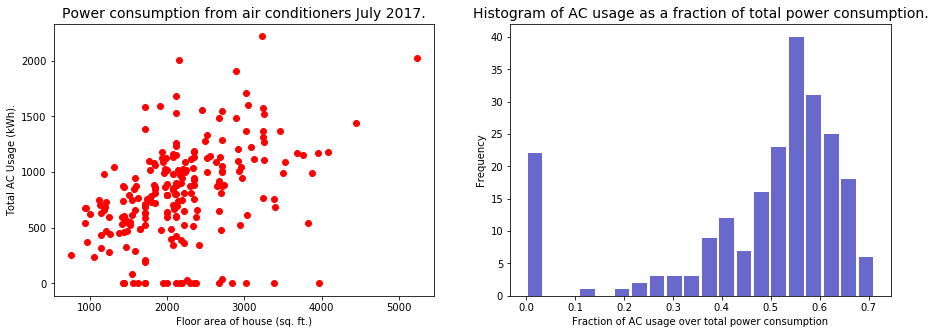

In [21]:
for house_id in dfData_houses.index.values:
    dfData_houses.at[house_id, 'ac_usage'] = (total_energy_all_days(house_id, 'air1') + 
                                              total_energy_all_days(house_id, 'air2') + 
                                              total_energy_all_days(house_id, 'air3') +
                                              total_energy_all_days(house_id, 'airwindowunit1')
                                          )
    dfData_houses.at[house_id, 'total_usage'] = total_energy_all_days(house_id, 'use')

fig, axs = plt.subplots(1, 2, figsize=(15,5))

axs[0].scatter(dfData_houses['area'].values, 
               dfData_houses['ac_usage'].values, 
               c='r', marker='o', label='AC usage'
              )
axs[0].set_xlabel('Floor area of house (sq. ft.)')
axs[0].set_ylabel('Total AC Usage (kWh).')
axs[0].set_title('Power consumption from air conditioners July 2017.', fontsize=14)

axs[1].hist(x=np.divide(dfData_houses['ac_usage'], dfData_houses['total_usage']), bins=20, alpha=0.6, color='#0504aa', rwidth=0.85)
axs[1].set_xlabel('Fraction of AC usage over total power consumption')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Histogram of AC usage as a fraction of total power consumption.', fontsize=14)

### Q6. Based on the above analysis, will you expect the total power consumption from customers to be more or less in October as compared to that in July? How does the above analysis compare to your analysis in Lab 1 on aggregate load prediction in Texas? (10 points)

The total power consumption from customers is less in October compared to that of July. Air conditioners seem to be the most popular power consumption utility in places, and because the weather in July is warmer than October, October will be less than July. 

This corresponds to lab 1 in that the temperature in summer is high in Texas, so the power is higher in July than October, like in this situation, because of air conditioners. 

### Q7. Can you think of a business case for the above histogram? (5 points, bonus)

A sample business case for this histogram would be for a local business in southern Texas that sells air conditioners that are more efficient, consuming less power to obtain a larger consumer base. 

### Compute monthly electric bills for each customer

Your electricity bill consists of various charges. These charges depend on the utility company you pay your electricity bill to. In Champaign, IL, your distribution utility company is Ameren. In Austin, a major distribution utility company is Austin Energy. Their bill structure is discussed in the following link:
https://austinenergy.com/ae/residential/rates/residential-electric-rates-and-line-items

Calculate the monthly bill of each household.

1. For each customer, compute the total energy consumed, available in the data field "use" over the month. Use the tiered rate structure to compute the total power bill for energy consumption.

2. For customers with PV panels, compute the total energy produced by the PV panels. Assume that Ameren Energy pays 9.7 cents/kWh for such production, and subtract the amount for solar power production from the power bill.

In [22]:
# Define a function that computes the electricity bill according to the structure defined by Austin Energy.

def electricity_bill(consumption):
    customer_charge = 10
    power_supply_adjustment = 2.895 * consumption / 100.0
    community_benefit_charge = (0.154 + 0.124 + 0.335) * consumption / 100.0
    regulatory_charge = 1.342 * consumption / 100.0
    
    tier_rate = [2.801, 5.832, 7.814, 9.314, 10.814]    
    tier_limits = [0, 500, 1000, 1500, 2500, math.inf]
    n_tiers = 5
    
    energy_charge = 0
    
    for tier in range(n_tiers):
        consumption_tier = min(max(consumption, tier_limits[tier]), tier_limits[tier + 1]) - tier_limits[tier]
        energy_charge += consumption_tier * tier_rate[tier] / 100.0
        
    return float('%.2f'%(1.01 * (energy_charge + customer_charge + power_supply_adjustment + community_benefit_charge
                   + regulatory_charge)))

for house_id in dfData_houses.index.values:
    dfData_houses.at[house_id, 'consumption_bill'] = electricity_bill(dfData_houses.loc[house_id, 'total_usage'])
    dfData_houses.at[house_id, 'pv_savings'] = total_energy_all_days(house_id, 'gen') * 9.7 / 100.0
    dfData_houses.at[house_id, 'electricity_bill'] = dfData_houses.loc[house_id, 'consumption_bill'] 
    - dfData_houses.loc[house_id, 'pv_savings']
    
    
print("Electricity bill computed for all customers.")

Electricity bill computed for all customers.


### What is a good indicator of electricity bill for consumption and savings from PV?

Electricity consumption significantly depends on floor area of a house. The dependency is even stronger, if the house is equipped with central AC. A scatter plot of the consumption bill against floor area reveals this dependency.

Monetary savings from PV panels depends on how many PV panels there are, which way they face, and how that relates to solar insolation. The number of panels installed largely depends on the roof area. The floor area of one of the floors is a good indicator. 

Text(0.5, 1.0, 'Monthly savings from PV panels over July 2017.')

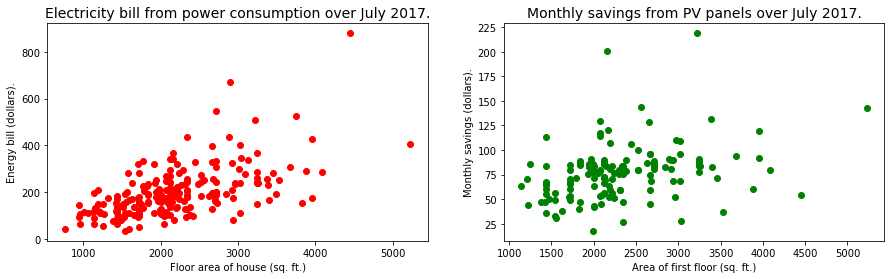

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(15,4))

# Plot of electricity bill for consumption against the square footage of the house.

axs[0].scatter(dfData_houses['area'].values, 
               dfData_houses['consumption_bill'].values, 
               c='r', marker='o', label='Electricity bill from consumption'
           )
axs[0].set_xlabel('Floor area of house (sq. ft.)')
axs[0].set_ylabel('Energy bill (dollars).')
axs[0].set_title('Electricity bill from power consumption over July 2017.', fontsize=14)

# Plot monetary savings from PV against the area of the first floor.

houses_without_pv = dfData_houses.loc[dfData_houses['pv'] == 0].index.values
houses_with_pv = dfData_houses.loc[dfData_houses['pv'] == 1].index.values

axs[1].scatter(dfData_houses.loc[houses_with_pv, 'area'].values, 
               dfData_houses.loc[houses_with_pv, 'pv_savings'].values, 
               c='g', marker='o', label='Savings from PV')

axs[1].set_xlabel('Area of first floor (sq. ft.)')
axs[1].set_ylabel('Monthly savings (dollars).')
axs[1].set_title('Monthly savings from PV panels over July 2017.', fontsize=14)

### Given the square footage of the house and the first floor, compute the electricity bill with and without PV.
 
Perform a linear regression on electricity bill and monthly savings from PV. Use the linear fits to compute the anticipated electricity bill with and without PV. Report your anticipated percentage savings with PV.

Use the data:
1. Square footage of entire house = 2450 sq. ft.
2. Square footage of first floor = 1380 sq. ft.

### Q8. Fill in the gaps below. Let's say you have $\$18,000$ to spend on a PV and get $\$2,500 $ in solar rebate . How long will it take (in years) for you to recover the initial investment?  (20 points)

In [28]:
area_house = 2450
area_first_floor = 1380

XX = dfData_houses['area'].values.reshape(-1, 1) 
YY = dfData_houses['consumption_bill'].values.reshape(-1, 1)

model_consumption = linear_model.LinearRegression()
model_consumption.fit(XX, YY)

predBill = model_consumption.predict(np.array([area_house]).reshape(-1, 1))
print("Predicted power bill = $%.2f" %  model_consumption.predict(np.array([area_house]).reshape(-1, 1)))

# Enter code here to compute predicted savings from PV 

XX = dfData_houses['area_floor'].values.reshape(-1, 1)
YY = dfData_houses['pv_savings'].values.reshape(-1, 1)

model_savings = linear_model.LinearRegression()
model_savings.fit(XX, YY)

predSavings = model_savings.predict(np.array([area_first_floor]).reshape(-1, 1))
print("Predicted savings from PV = $%.2f" % predSavings)

del XX, YY

price = 18000
rebate = 2500

years = (math.ceil((price - rebate) / predSavings)) / 12

print(f"Predicted number of years to recover = {years} ")

Predicted power bill = $221.84
Predicted savings from PV = $47.89
Predicted number of years to recover = 27.0 
